In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GNNExplainer

import numpy as np
import pandas as pd
import more_itertools as mit

from typing import List
from torch_geometric.data import InMemoryDataset

import matplotlib.pyplot as plt

In [2]:
def reasonable_notebook_defaults():
    r"""Notbook defaults"""
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_context("paper", font_scale=1.5)
    plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
reasonable_notebook_defaults()

In [4]:
doc0 = ["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
doc1 = ["Welcome", "to", "the", "dog", "days", "of", "summer"]
docs = [doc0, doc1]
vocab = set(doc0 + doc1)

In [5]:
vocab_to_int = {term: token for token, term in enumerate(vocab)}
int_to_vocab = {token: term for term, token in vocab_to_int.items()}

In [6]:
def tokenize(sent):
    """Map sentence to tokens"""
    return [vocab_to_int[word] for word in sent]


def untokenize(sent):
    """Map tokens to sentence"""
    return [int_to_vocab[token] for token in sent]


def one_hot_encode(sent):
    """One hot encode a sentence"""
    return np.stack([token_to_one_hot(x) for x in sent])


def decode_one_hot(encoding) -> List[str]:
    """Decode a one hot encoding back to sentence"""
    return [one_hot_word_to_token(x) for x in encoding]


def token_to_one_hot(token):
    """One hot encode a token"""
    word = np.zeros(len(vocab), dtype=int)
    word[token] = 1
    return word


def one_hot_word_to_token(one_hot_word):
    """Convert one hot encoded word to token"""
    return int_to_vocab[np.argmax(one_hot_word)]

In [7]:
tokenized = [tokenize(x) for x in docs]
sentences = [untokenize(x) for x in tokenized]

In [8]:
sentences

[['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog'],
 ['Welcome', 'to', 'the', 'dog', 'days', 'of', 'summer']]

In [9]:
onehot_encoded = one_hot_encode(tokenized[0])

In [10]:
one_hot_token = token_to_one_hot(tokenized[0][0])

In [11]:
one_hot_token

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [12]:
one_hot_word_to_token(one_hot_token)

'The'

In [13]:
onehot_encoded

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [14]:
decode_one_hot(onehot_encoded)

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

### Integer Tokens:

In [15]:
doc0 = [x for x in range(10)]
doc1 = [x for x in range(5, 15)]
docs = [doc0, doc1]
vocab = set(doc0 + doc1)

In [16]:
vocab_to_int = {term: token for token, term in enumerate(vocab)}
int_to_vocab = {token: term for term, token in vocab_to_int.items()}

In [17]:
vocab

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [18]:
docs

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [19]:
tokenized = [tokenize(x) for x in docs]
sentences = [untokenize(x) for x in tokenized]

In [20]:
onehot_encoded = one_hot_encode(tokenized[0])
one_hot_token = token_to_one_hot(tokenized[0][0])
one_hot_word_to_token(one_hot_token)

0

In [21]:
onehot_encoded

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Edge List

In [22]:
doc0 = ["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
doc1 = ["Welcome", "to", "the", "dog", "days", "of", "summer"]
docs = [doc0, doc1]
vocab = set(doc0 + doc1)

In [23]:
doc = ["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
doc_idxs = [x for x in range(len(doc))]

In [24]:
vocab_to_int = {term: token for token, term in enumerate(vocab)}
int_to_vocab = {token: term for term, token in vocab_to_int.items()}

In [25]:
def create_edge_list(doc_idxs, num_neighbors=1):
    """Create an edge list for a document
    
    Iteratively build a list of graph edges.
    We connect `neighbors` in a document, the 
    words to the left and right of a document
    by `num_neighbors` distance.
    
    Args:
        doc_idxs: list of document indices
        num_neighbors: number of neighbors to
        connect to each node.
        
    Returns:
        edge_list: list of connected nodes 
        for a Pytorch Geometric graph
    """
    edge_list = []
    for neighbor in range(num_neighbors):
        edge_list.extend(
            get_neighbors(doc_idxs, neighbor+1)
        )
        
    reverse_pairs = get_reverse_pairs(edge_list)
    edge_list.extend(reverse_pairs)
    edge_list.sort()
    
    return edge_list

In [26]:
def get_neighbors(doc_idxs, neighbor_distance):
    """Get pairs of neighbors at a given neighbor_distance
    
    For every index in `doc_idxs`, we get its neighbor a given
    distance away.
    
    Args:
        doc_idxs: list of document indices
        neighbor_distance: distance between neighboring terms to be paired
        
    Returns:
        neighbors: list of neighbor pairs
    """
    neighbors = list(mit.windowed(doc_idxs, neighbor_distance+1))
    neighbors = [[x[0], x[-1]] for x in neighbors]
    return neighbors

In [27]:
def get_reverse_pairs(edge_list):
    """Get the reverse of edge list pairs
    
    This is required by Pytorch Geometric datasets.
    """
    return [[x[1], x[0]] for x in edge_list]

In [28]:
edge_list = create_edge_list(doc_idxs, num_neighbors=1)

In [29]:
edge_list

[[0, 1],
 [1, 0],
 [1, 2],
 [2, 1],
 [2, 3],
 [3, 2],
 [3, 4],
 [4, 3],
 [4, 5],
 [5, 4],
 [5, 6],
 [6, 5],
 [6, 7],
 [7, 6],
 [7, 8],
 [8, 7]]

In [30]:
edge_index = torch.tensor(edge_list, dtype=torch.long)

In [31]:
tokens = tokenize(doc)

In [32]:
tokens = [[x] for x in tokens]

In [33]:
x = torch.tensor(tokens, dtype=torch.float)
y = torch.randint(0, 6, (9, ), dtype=torch.long)

In [34]:
data = Data(x=x, y=y, edge_index=edge_index.t().contiguous())

In [35]:
data

Data(edge_index=[2, 16], x=[9, 1], y=[9])

In [36]:
data.num_nodes

9

## Model Explainer

In [37]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 10)
        self.conv2 = GCNConv(10, 10)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

Explain node 8: 100%|██████████| 200/200 [00:00<00:00, 705.99it/s]


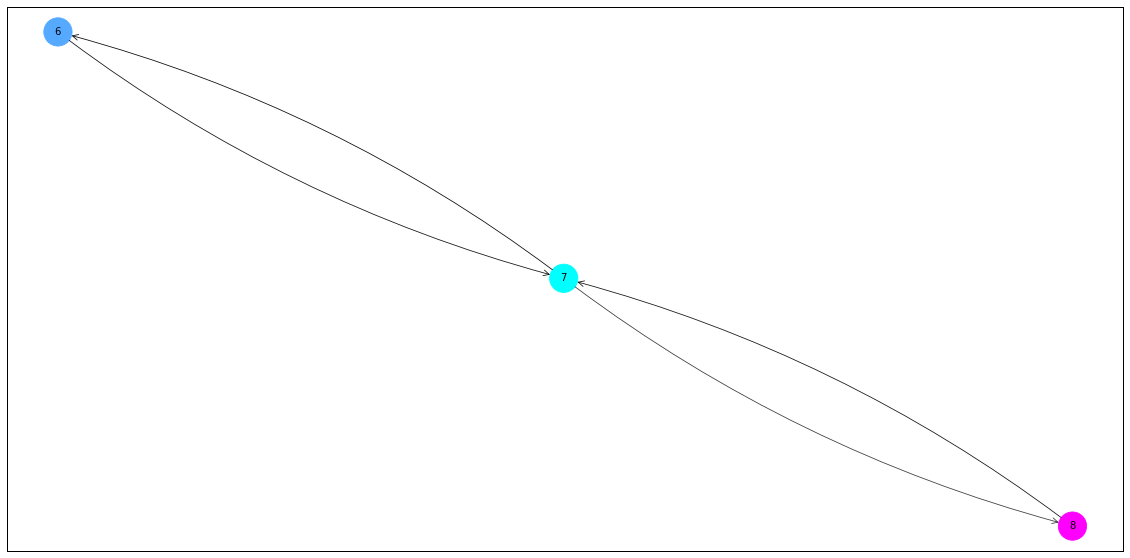

In [39]:
explainer = GNNExplainer(model, epochs=200)

node_idx = 8
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()